In [1]:
!gsutil -m cp gs://custom-prediction-1/model/cats_vs_dogs.h5 .

Copying gs://custom-prediction-1/model/cats_vs_dogs.h5...
/ [1/1 files][  8.9 MiB/  8.9 MiB] 100% Done                                    
Operation completed over 1 objects/8.9 MiB.                                      


In [3]:
import tensorflow as tf
model = tf.keras.models.load_model('cats_vs_dogs.h5')
model.summary()

2023-09-08 09:05:50.280991: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/nccl2/lib:/usr/local/cuda/extras/CUPTI/lib64
2023-09-08 09:05:50.281855: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-08 09:05:50.281889: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (instance-20230908-130143): /proc/driver/nvidia/version does not exist
2023-09-08 09:05:50.283748: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [8]:
classes = ['Cat', 'Dog']

def disp_pred(img_path):
    plt.imshow(plt.imread(img_path))
    
    x = tf.keras.preprocessing.image.load_img(img_path, target_size=(128, 128))
    x = tf.keras.preprocessing.image.img_to_array(x)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
    x = np.expand_dims(x, axis=0)
    
    pred = model.predict(x)[0]
    
    plt.title('Pred: {}'.format(classes[int(pred > 0.5)]))
    plt.show()
    
    print(pred)
    

1/1 [==============================] - 1s 995ms/step


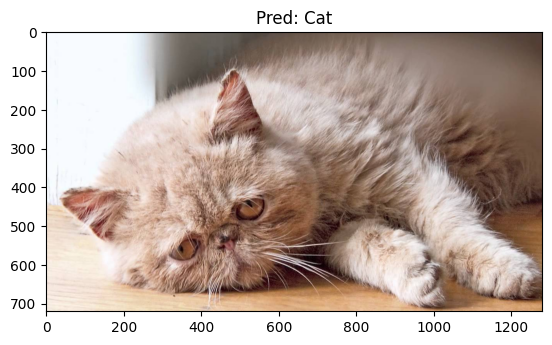

[0.00425033]


In [9]:
images = ['images/cat1.jpg', 'images/cat2.jpg', 'images/dog1.jpg', 'images/dog2.jpg']

disp_pred(images[0])

1/1 [==============================] - 0s 43ms/step


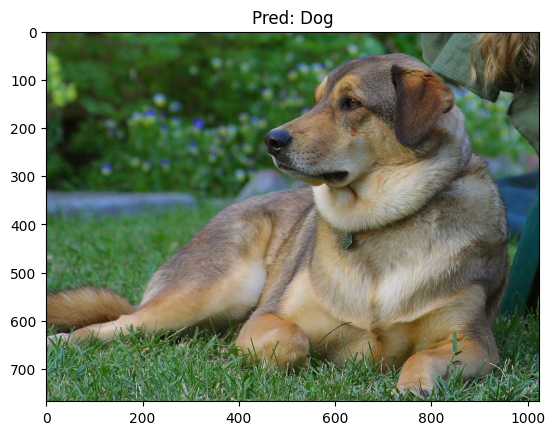

[0.9928476]


In [10]:
disp_pred(images[-1])

In [11]:
%%writefile prediction.py

import tensorflow as tf
import numpy as np
import os
import base64

MODEL_NAME = 'cats_vs_dogs.h5'
CLASS_NAMES = ['Cat', 'Dog']

class CatsvsDogsPred:
    def __init__(self, model):
        self._model = model
        
    def _preprocess(self, instances, size=128):
        num_ex = len(instances)
        x_batch = np.zeros((num_ex, size, size, 3))
        for i in range(num_ex):
            x = np.array(bytearray(base64.b64decode(instances[i])))
            x = np.reshape(x, (size, size, 3))
            x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
            x_batch[i] = x
        return x_batch
    
    def _postprocess(self, preds):
        results = []
        for i, pred in enumerate(preds):
            p = np.squeeze(pred)
            results.append({
                'index': i,
                'class_name': CLASS_NAMES[int(p -> 0.5)],
                'raw_value': '{:.4f}'.format(p)
            })
        return results
        
    def predict(self, instances, **kwargs):
        if 'size' in kwargs:
            size = int(kwargs.get('size'))
        else:
            size = 128
        #preprocess
        x_batch = self.preprocess(instances, size)
        #predict
        preds = self._model.predict(x_batch)
        #post process
        return
        
    @classmethod
    def from_path(cls, model_dir):
        model = tf.keras.models.load_model(os.path.join(model_dir, MODEL_NAME))
        return cls(model)

Writing prediction.py


In [17]:
%%writefile setup.py

from setuptools import setup

setup(
    name='cats_vs_dogs',
    version='0.0.1',
    include_package_data=False,
    scripts=['prediction.py']
)

Overwriting setup.py


In [18]:
!python3 setup.py sdist --formats=gztar

running sdist
running egg_info
creating src/cats_vs_dogs.egg-info
writing src/cats_vs_dogs.egg-info/PKG-INFO
writing dependency_links to src/cats_vs_dogs.egg-info/dependency_links.txt
writing top-level names to src/cats_vs_dogs.egg-info/top_level.txt
writing manifest file 'src/cats_vs_dogs.egg-info/SOURCES.txt'
reading manifest file 'src/cats_vs_dogs.egg-info/SOURCES.txt'
writing manifest file 'src/cats_vs_dogs.egg-info/SOURCES.txt'

running check
creating cats_vs_dogs-0.0.1
creating cats_vs_dogs-0.0.1/src
creating cats_vs_dogs-0.0.1/src/cats_vs_dogs.egg-info
creating cats_vs_dogs-0.0.1/src/models
creating cats_vs_dogs-0.0.1/src/models/official
creating cats_vs_dogs-0.0.1/src/models/official/common
creating cats_vs_dogs-0.0.1/src/models/official/core
creating cats_vs_dogs-0.0.1/src/models/official/legacy
creating cats_vs_dogs-0.0.1/src/models/official/legacy/albert
creating cats_vs_dogs-0.0.1/src/models/official/legacy/bert
creating cats_vs_dogs-0.0.1/src/models/official/legacy/detecti

In [20]:
!gsutil cp dist/cats_vs_dogs-0.0.1.tar.gz gs://custom-prediction-1/dist/

Copying file://dist/cats_vs_dogs-0.0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  3.9 MiB/  3.9 MiB]                                                
Operation completed over 1 objects/3.9 MiB.                                      
